In [1]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive
    import os

    drive.mount('/content/drive')
    os.chdir('/content/drive/Shareddrives/Confidence Probes/taskdiscovery')
    !pip3 install transformer_lens fancy_einsum einops datasets encoders plotly

else:
    print("Not running in Google Colab, skipping installation of requirements.")

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.5/594.5 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 69.1 MB/s eta

In [2]:
import sys
# del sys.modules["data"]

In [58]:
from transformer_lens import HookedTransformer
from datasets import load_dataset
from data import load_ICL_dataset,word_pairs_to_prompt_data,create_prompt,FVDataset,retrieve_owt_data
from training_utils import fit_beta_model
from torch.utils.data import DataLoader
from fancy_einsum import einsum
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from torch.nn import functional as F
from functools import partial
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import torch
import math
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score
from sklearn.cluster import KMeans,SpectralClustering
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from scipy.optimize import linear_sum_assignment
from collections import Counter
import random
import os

In [4]:
batch_size = 32
ctx_length = 64
model_name = "gpt2-small"
device = torch.device("cuda")
model = HookedTransformer.from_pretrained(model_name, device=device)
tokenizer = model.tokenizer
# owt_loader = retrieve_owt_data(batch_size, ctx_length, tokenizer)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer


Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/100000 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (58948 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (59558 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (61422 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (71857 > 1024). Running this sequence through the model will result in indexing errors


In [293]:
d = {"prompt":[], "label": [], "task" : []}
included_tasks = ["present-past", "capitalize",  "singular-plural", "antonym","word_length", "next_capital_letter"]

for task in os.listdir("function_vectors_data/abstractive"):
    task = task.replace(".json", "")
    dataset = load_ICL_dataset(task)

    if task in included_tasks:
        print(task, "train len:", len(dataset['train']), "test len:",len(dataset['test']) )

    for test_pair in dataset['test']:
        for i in range(10):
            choices = random.choices(dataset['train'],k=5)
            word_pairs = {"input": [x["input"] for x in choices],
                        "output": [x["output"] for x in choices]}
            prompt_data = word_pairs_to_prompt_data(word_pairs, query_target_pair=test_pair, prepend_bos_token=True)
            sentence = create_prompt(prompt_data)
            d["prompt"].append(sentence)
            d["label"].append(test_pair["output"])
            d["task"].append(task)

    for test_pair in dataset['train']:
      for i in range(10):
          choices = random.choices(dataset['test'],k=5)
          word_pairs = {"input": [x["input"] for x in choices],
                      "output": [x["output"] for x in choices]}
          prompt_data = word_pairs_to_prompt_data(word_pairs, query_target_pair=test_pair, prepend_bos_token=True)
          sentence = create_prompt(prompt_data)
          d["prompt"].append(sentence)
          d["label"].append(test_pair["output"])
          d["task"].append(task)

df = pd.DataFrame(d)

capitalize train len: 569 test len: 170
antonym train len: 1678 test len: 504
next_capital_letter train len: 569 test len: 171
present-past train len: 205 test len: 61
singular-plural train len: 143 test len: 43
word_length train len: 569 test len: 171


In [295]:
min_len = 10000

for task in included_tasks:
    task_set = df[df["task"] == task]
    if len(task_set) < min_len:
        min_len = len(task_set)

print("data points per task", min_len)

task_dfs = []
for task in included_tasks:
    task_set = df[df["task"] == task].copy().reset_index()
    task_dfs.append(task_set.iloc[np.random.choice(len(task_set), min_len)])

df_subset = pd.concat(task_dfs)


data points per task 1860


In [7]:
df_subset.sample()

,index,prompt,label,task
207,420497,<|endoftext|>Q: improve\nA: improved\n\nQ: pre...,gave,present-past


In [8]:
df.task.unique()

array(['ag_news', 'capitalize', 'antonym', 'capitalize_first_letter',
       'capitalize_last_letter', 'capitalize_second_letter',
       'commonsense_qa', 'country-capital', 'country-currency',
       'english-french', 'english-german', 'english-spanish',
       'landmark-country', 'lowercase_first_letter',
       'lowercase_last_letter', 'national_parks', 'next_item',
       'next_capital_letter', 'park-country', 'person-instrument',
       'person-occupation', 'person-sport', 'prev_item', 'present-past',
       'product-company', 'sentiment', 'singular-plural', 'synonym',
       'word_length'], dtype=object)

In [296]:
tokenized_data = []
tasks = []
labels = []

for idx,row in df_subset.iterrows():
    x = tokenizer(row["prompt"], max_length=64, truncation=True, padding='max_length', return_tensors="pt")
    if x['attention_mask'][-1,-1] == 1:
        continue
    tokenized_data.append(x)
    tasks.append(row["task"])
    labels.append(row["label"])

print(len(tokenized_data))

11073


In [297]:
dataset = FVDataset(tokenized_data,tasks, labels)

batch_size = 1
dl = DataLoader(dataset, batch_size=batch_size, shuffle=False,drop_last=True)

In [298]:
tokenizer.batch_decode(next(iter(dl))[0])

/content/drive/Shareddrives/Confidence Probes/taskdiscovery/data.py:558: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/content/drive/Shareddrives/Confidence Probes/taskdiscovery/data.py:559: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



['<|endoftext|>Q: publish\nA: published\n\nQ: describe\nA: described\n\nQ: reach\nA: reached\n\nQ: balance\nA: balanced\n\nQ: begin\nA: began\n\nQ: set\nA:<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>']

In [299]:
model.cfg.use_attn_result = True
n_layers = 12

def save_(save_to, result, hook):
  save_to.append(result)
  return result

def attn_filter(name):
  return name.endswith("attn.hook_result")

def pattern_filter(name):
  return name.endswith("pattern")

def pre_filter(name):
  return name.endswith("resid_pre")


attention_results = 0
all_activations = []
tasks = []
entropies = []
corrects= 0

mean_samples = 0

for batch in tqdm(dl):
  with torch.no_grad():
    attn_storage = []
    act_storage = []
    pattern_storage = []
    attn_mask =  batch[1]
    # batch x tokens x vocab size
    output = model.run_with_hooks(
                    batch[0],
                    attention_mask = batch[1],
                    fwd_hooks=[(attn_filter,partial(save_, attn_storage),) ] +
                    [(pre_filter,partial(save_, act_storage),) ] +
                    [(pattern_filter,partial(save_, pattern_storage),) ]

            )

    # will return a tensor with shape batch size with indices of last token
    last_token_idx = attn_mask.cumsum(1).argmax(1)

    activations = torch.stack(act_storage)[:, torch.arange(batch_size), last_token_idx, :]


    mean_samples += attn_mask[:,1:].sum()

    # attn_mask: [bsz, seq_pos]
    # attn_storage: [n_layers, bsz, seq_pos, n_heads, d_model]
    # attention_results : [n_layers, n_heads, d_model]
    attention_results += (torch.stack(attn_storage, dim=0) * attn_mask.unsqueeze(-1).unsqueeze(-1).to(device))[:,1:].sum(dim=[1,2]).cpu()

    labels = batch[-1]


    predicted_labels = tokenizer.batch_decode(output[torch.arange(batch_size), last_token_idx,:].argmax(-1))


    # pattern_storage: [n_layers, bsz, n_heads, seq_pos, seq_pos]
    patterns = torch.stack(pattern_storage).permute(0,2,1,3,4)[:,:,torch.arange(batch_size), last_token_idx, :].permute(2,0,1,3)
    entropy = (- patterns * (patterns + 1e-10).log()).sum(-1).flatten(1,2)
    # entropy: [bsz, n_layers * n_heads]
    entropies.append(entropy.cpu())
    all_activations.append(activations.cpu())
    tasks += list(batch[2])


100%|██████████| 11073/11073 [09:07<00:00, 20.21it/s]


In [308]:
all_activations

tensor([[[ 4.2381e-02, -1.8892e-01,  4.7194e-02,  ...,  2.3389e-02,
          -8.5577e-02, -2.9744e-02],
         [ 4.2381e-02, -1.8892e-01,  4.7194e-02,  ...,  2.3389e-02,
          -8.5577e-02, -2.9744e-02],
         [ 4.2381e-02, -1.8892e-01,  4.7194e-02,  ...,  2.3389e-02,
          -8.5577e-02, -2.9744e-02],
         ...,
         [ 4.5574e-02, -1.9409e-01,  4.9904e-02,  ...,  2.2257e-02,
          -8.5143e-02, -2.6756e-02],
         [ 4.1662e-02, -1.9055e-01,  5.6020e-02,  ...,  2.1198e-02,
          -8.5818e-02, -2.7789e-02],
         [ 4.5574e-02, -1.9409e-01,  4.9904e-02,  ...,  2.2257e-02,
          -8.5143e-02, -2.6756e-02]],

        [[ 7.4377e-02,  2.2217e-01,  9.0505e-01,  ...,  9.5417e-02,
          -1.5693e-01,  5.8766e-01],
         [ 5.0972e-02,  1.9880e-01,  7.6098e-01,  ...,  5.8398e-02,
          -1.7099e-01,  5.8854e-01],
         [ 3.3598e-01,  7.7056e-02,  9.7504e-01,  ...,  6.3584e-02,
          -1.3656e-01,  5.3919e-01],
         ...,
         [ 1.7058e-01,  2

In [302]:
mean_attn = (attention_results/mean_samples).to(device)
all_activations = torch.cat(all_activations, 1)
entropies = torch.cat(entropies,0)

print("mean attn shape:" , mean_attn.shape)
print("all activations shape:", all_activations.shape)
print("entropies shape:", entropies.shape)

TypeError: cat() received an invalid combination of arguments - got (Tensor, int), but expected one of:
 * (tuple of Tensors tensors, int dim, *, Tensor out)
 * (tuple of Tensors tensors, name dim, *, Tensor out)


In [301]:
def fit_cluster(x,y):
  label_encoder = LabelEncoder()
  true_labels = label_encoder.fit_transform(y)

  train_x, test_x, train_y, test_y = train_test_split(x, true_labels)

  kmeans = KMeans(n_clusters=len(Counter(true_labels)),n_init ="auto", random_state=0).fit(train_x)

  predicted_labels = kmeans.labels_

  M = confusion_matrix(train_y, predicted_labels )
  row, col = linear_sum_assignment(M,maximize= True)
  map = {}
  for i in range(len(row)):
    map[row[i]] = col[i]

  vectorized_map = np.vectorize(lambda x: map.get(x, x))
  train_y = vectorized_map(train_y)
  test_y = vectorized_map(test_y)

  # Calculate "accuracy"
  accuracy = accuracy_score(train_y, predicted_labels)
  print(f"train accuracy: {accuracy}")

  test_predict = kmeans.predict(test_x)

  # Calculate "accuracy"
  test_accuracy = accuracy_score(test_y, test_predict)
  print(f"test accuracy: {test_accuracy}")
  return kmeans.predict(x)



In [309]:
pca = PCA()
pca_projections = pca.fit_transform(entropies)
cluster_predictions = fit_cluster(pca_projections[:, :5],tasks)

train accuracy: 0.7204961464354528
test accuracy: 0.7233658360418924


<Axes: >

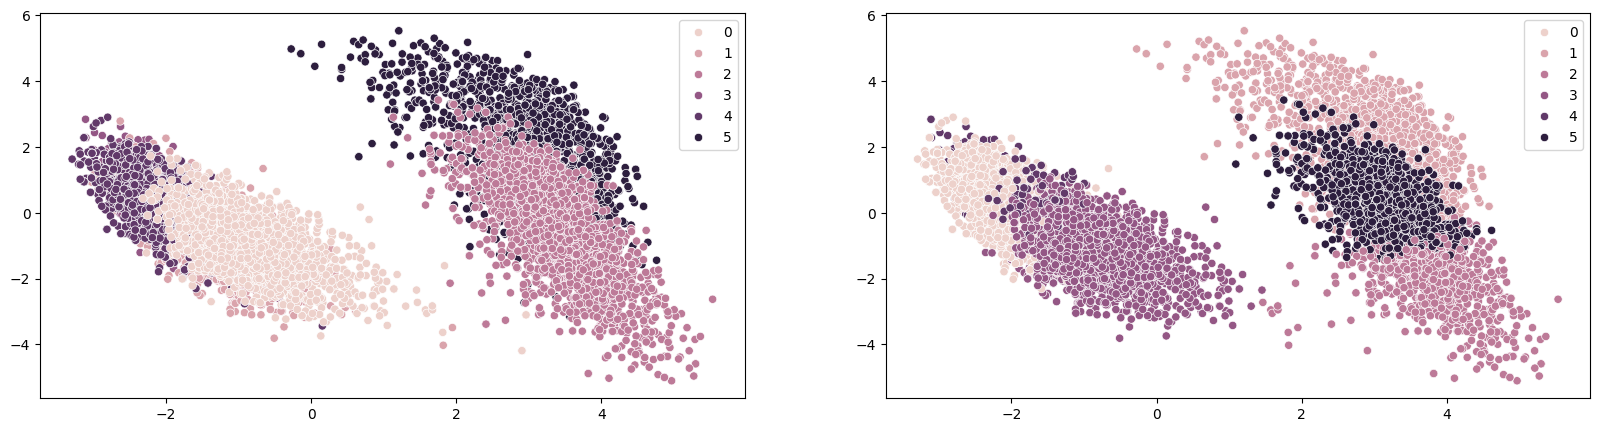

In [310]:
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(tasks)
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
sns.scatterplot(x= pca_projections[:,0], y =pca_projections[:,1],hue=true_labels)
plt.subplot(1,2,2)
sns.scatterplot(x= pca_projections[:,0], y =pca_projections[:,1],hue=cluster_predictions)

In [311]:
def fit_linreg(x, y):
    label_encoder = LabelEncoder()
    true_labels = label_encoder.fit_transform(y)

    train_x, test_x,train_y, test_y, = train_test_split(x, true_labels)

    lm = LogisticRegression(random_state=0).fit(train_x, train_y)

    predicted_labels = lm.predict(train_x)

    # Calculate "accuracy"
    accuracy = accuracy_score(train_y, predicted_labels)
    print(f"train accuracy: {accuracy}")

    test_predict = lm.predict(test_x)

    # Calculate "accuracy"
    test_accuracy = accuracy_score(test_y, test_predict)
    print(f"test accuracy: {test_accuracy}")

    return accuracy, test_accuracy

In [312]:
_,_ = fit_linreg(entropies, tasks)

train accuracy: 0.9998795761078998
test accuracy: 0.9989165763813651


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [61]:
# Set the figure size
plt.figure(figsize=(20, 20))
# Create 10 subplots, using PCA 1 as x-axis and PCA 2 to PCA 11 as y-axis
for i in range(1, 21):
    plt.subplot(5, 4, i)  # Adjust the grid size if needed
    sns.scatterplot(x=pca_projections[:, 0], y=pca_projections[:, i], hue=true_labels, palette='viridis')
    plt.title(f'PCA 1 vs PCA {i+1}')
    plt.xlabel('PCA 1')
    plt.ylabel(f'PCA {i+1}')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [73]:
x = pca_project(entropies,10)[:,0]
y = pca_project(entropies,10)[:,3]
z = pca_project(entropies,10)[:,4]

fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=5,  # Adjust marker size here
        color=true_labels,  # Set marker color to the true labels
        colorscale='Viridis',  # Color scale for labels
        opacity=0.8  # Adjust marker opacity
    )
)])

# Update plot layout
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0),  # Adjust margins to fit your needs
    scene=dict(
        xaxis_title='PCA Component 1',
        yaxis_title='PCA Component 2',
        zaxis_title='PCA Component 3'
    )
)

# Show the plot
fig.show()

In [313]:
for layer in range(n_layers):
  x = all_activations[layer]
  print(f"Layer {layer}")
  fit_cluster(x, tasks)
  print(f"Layer {layer} pca")
  pca = PCA()
  pca_projections = pca.fit_transform(x)
  fit_cluster(pca_projections[:,:], tasks)

Layer 0
train accuracy: 0.38391136801541426
test accuracy: 0.38678223185265437
Layer 0 pca
train accuracy: 0.37909441233140656
test accuracy: 0.3755868544600939
Layer 1
train accuracy: 0.5859826589595376
test accuracy: 0.600216684723727
Layer 1 pca
train accuracy: 0.5758670520231214
test accuracy: 0.6041892379920549
Layer 2
train accuracy: 0.7011078998073218
test accuracy: 0.6962802455760202
Layer 2 pca
train accuracy: 0.6938824662813102
test accuracy: 0.6991693752257132
Layer 3
train accuracy: 0.5939306358381503
test accuracy: 0.5919104369808595
Layer 3 pca
train accuracy: 0.5865847784200385
test accuracy: 0.5929938605994944
Layer 4
train accuracy: 0.4975915221579961
test accuracy: 0.47815095702419647
Layer 4 pca
train accuracy: 0.5743015414258189
test accuracy: 0.5698808234019501
Layer 5
train accuracy: 0.5013246628131022
test accuracy: 0.49151318165402674
Layer 5 pca
train accuracy: 0.4707369942196532
test accuracy: 0.46153846153846156
Layer 6
train accuracy: 0.7518063583815029
test

In [314]:
attention_scores = []

# n_heads * batch_size x tokens x n_heads x dim
# [i ,:,i,:] will be 1s
seq_len = 64
mask = torch.eye(12,device = device).unsqueeze(1).unsqueeze(-1).bool()
mask = mask.expand(-1, seq_len - 1, -1, 768).repeat_interleave(batch_size,dim=0)

def attn_mean_ablation(mean, result, hook):
  n_heads = model.cfg.n_heads
  result[-n_heads * batch_size:,1:] = torch.where(mask, mean.unsqueeze(0).unsqueeze(0).repeat(n_layers*batch_size,seq_len-1,1,1).to(device), result[-n_layers* batch_size:,1:])
  return result

def increase_batch(act,hook):
  return torch.cat([act,act[:batch_size].repeat(n_layers,1,1)],0)

def attn_filter_layer(i,name):
  return name.endswith(f"{i}.attn.hook_result")

def pre_filter(name):
  return name.endswith("resid_pre")


idx = 0
d
kls = []
tasks = []

for batch in tqdm(dl):
  with torch.no_grad():

    output = model.run_with_hooks(
                    batch[0],
                    attention_mask = batch[1],
                    fwd_hooks=[(partial(attn_filter_layer,i),partial(attn_mean_ablation, mean_attn[i]),)  for i in range(n_layers)] +
                    [(pre_filter,increase_batch)]
            )

    attn_mask = batch[1]
    last_token_idx = attn_mask.cumsum(1).argmax(1)
    output = output.unflatten(0,(-1,batch_size))
    output = output[:,torch.arange(batch_size), last_token_idx,:]

    kl_loss = F.kl_div(output[1:].softmax(-1).log(), output[0:1].softmax(-1), reduction = 'none').sum(-1).T

    kls.append(kl_loss.cpu().numpy())
    tasks+= list(batch[2])
    # print(tokenizer.decode(batch[0].squeeze()) ,tokenizer.decode(output.argmax(-1)[0]))

    idx += 1


  0%|          | 0/11073 [00:00<?, ?it/s]/content/drive/Shareddrives/Confidence Probes/taskdiscovery/data.py:558: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/content/drive/Shareddrives/Confidence Probes/taskdiscovery/data.py:559: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

100%|██████████| 11073/11073 [37:11<00:00,  4.96it/s]


In [316]:
importances = np.concatenate(kls,0)

In [317]:
_ = fit_cluster(importances,tasks)
pca = PCA().fit(importances)

_ = fit_cluster(pca.transform(importances)[:,:4], tasks)

train accuracy: 0.42124277456647397
test accuracy: 0.4109786926688335
train accuracy: 0.3878853564547206
test accuracy: 0.39075478512098233


In [318]:
fit_linreg(importances, tasks)

train accuracy: 0.9666425818882466
test accuracy: 0.9682195738533766


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



(0.9666425818882466, 0.9682195738533766)

<Axes: ylabel='Count'>

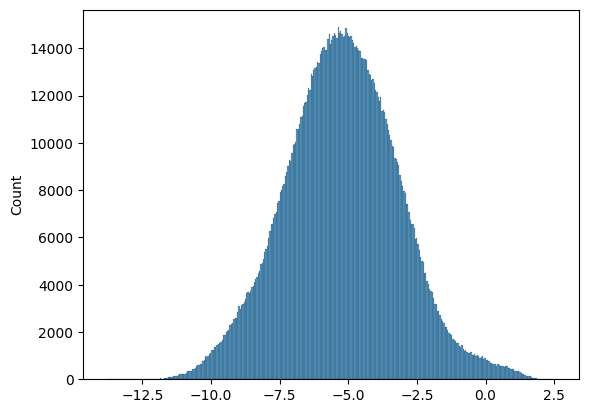

In [319]:
sns.histplot(np.log(importances.flatten()))

In [239]:
pca = PCA().fit(np.log(importances))
pca_reduced_impt = pca.transform(np.log(importances))
true_labels = label_encoder.fit_transform(tasks)

In [201]:
pca = PCA().fit(importances)
pca_reduced_impt = pca.transform(importances)
pca_results = fit_cluster(pca_reduced_impt[:,:5], tasks)

train accuracy: 0.4781760546208242
test accuracy: 0.48500365764447695


In [240]:
_ = fit_cluster(importances, tasks)
pca = PCA().fit(np.log(importances))
pca_reduced_impt = pca.transform(np.log(importances))
pca_results = fit_cluster(pca_reduced_impt[:,:5], tasks)

train accuracy: 0.5049987807851744
test accuracy: 0.5032918800292612
train accuracy: 0.5596196049743964
test accuracy: 0.5544989027066569


In [320]:
importances_normalized = (np.log(importances) - np.log(importances).mean(-1)[...,np.newaxis])   /  np.log(importances).std(-1)[...,np.newaxis]
pca = PCA().fit(importances_normalized)
pca_reduced_impt = pca.transform(importances_normalized)
pca_results = fit_cluster(pca_reduced_impt[:,:5], tasks)

train accuracy: 0.7455443159922929
test accuracy: 0.7562296858071506


In [347]:
spearmanr(importances_normalized[:,i], entropies[:,i])[0]

-0.15600019307383725

In [349]:
importances_normalized[:,i]

array([1.1678864, 2.1071956, 2.5719292, ..., 0.8520208, 2.514839 ,
       1.833064 ], dtype=float32)

In [353]:
spearmanr(importances_normalized[:,i], entropies[:,i].numpy())

SignificanceResult(statistic=-0.15600019307383725, pvalue=2.8622574585171233e-61)

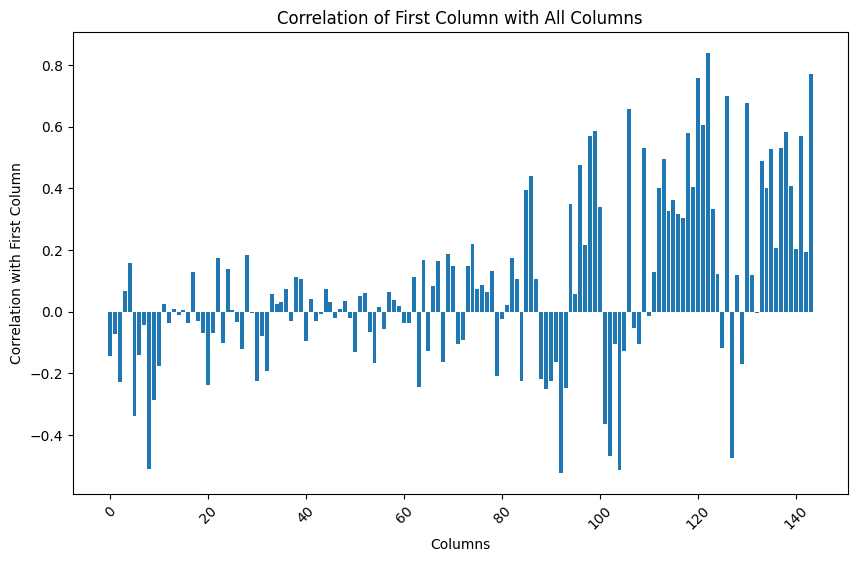

In [357]:
corrs = []
for i in range(144):
  corrs.append(spearmanr(importances[:,i], entropies[:,i].numpy())[0])

plt.figure(figsize=(10, 6))
plt.bar(list(range(len(corrs))), corrs)
plt.xlabel('Columns')
plt.ylabel('Correlation with First Column')
plt.title('Correlation of First Column with All Columns')
plt.xticks(rotation=45)  # Rotate labels to make them readable
plt.show()


In [321]:
corrs = 0
for i in range(144):
  corrs += pd.DataFrame([entropies[:, i].numpy(), importances[:,i]]).T.corr("spearman").values[1][0]

print(corrs/144)

0.08094276456473279


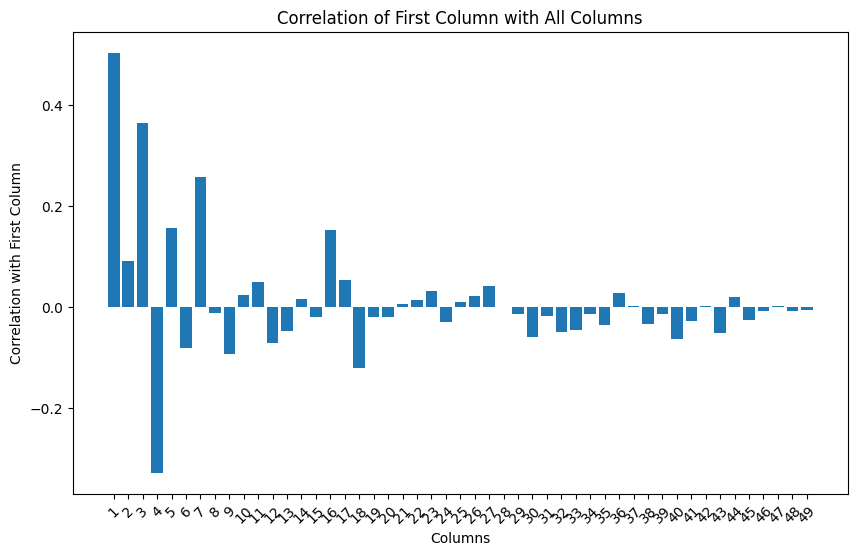

In [338]:
first_col_corr = pd.DataFrame(np.concatenate([entropies.mean(-1).numpy()[...,np.newaxis], pca_reduced_impt], axis = 1)).corr("spearman").iloc[1:50, 0]


plt.figure(figsize=(10, 6))
plt.bar(first_col_corr.index.astype(str), first_col_corr.values)
plt.xlabel('Columns')
plt.ylabel('Correlation with First Column')
plt.title('Correlation of First Column with All Columns')
plt.xticks(rotation=45)  # Rotate labels to make them readable
plt.show()

In [331]:
first_col_corr

0         <|endoftext|>Q: Chinese economy surges 9.5 in ...
1         <|endoftext|>Q: Virgin tunes into the online m...
2         <|endoftext|>Q: Sudan vows to restore order to...
3         <|endoftext|>Q: Langer leads the Australian ch...
4         <|endoftext|>Q: Novak, Canas Top Dogs Left at ...
                                ...                        
473755    <|endoftext|>Q: finch\nA: 5\n\nQ: inventive\nA...
473756    <|endoftext|>Q: hyena\nA: 5\n\nQ: kangaroo\nA:...
473757    <|endoftext|>Q: notebook\nA: 8\n\nQ: nurture\n...
473758    <|endoftext|>Q: eager\nA: 5\n\nQ: plantain\nA:...
473759    <|endoftext|>Q: fear\nA: 4\n\nQ: dog\nA: 3\n\n...
Name: prompt, Length: 473760, dtype: object

In [323]:
entropies.mean(-1).numpy().shape

(11073,)

In [324]:
pca_reduced_impt.shape

(11073, 144)

In [326]:
from scipy.stats import spearmanr

print(spearmanr(entropies.mean(-1), pca_reduced_impt[:,0]))
print(spearmanr(entropies.mean(-1), pca_reduced_impt[:,1]))

SignificanceResult(statistic=0.5030705629558777, pvalue=0.0)
SignificanceResult(statistic=0.09195307031802417, pvalue=3.1502644145725387e-22)


In [247]:
df.

torch.Size([5468])

Text(0, 0.5, 'PC 2')

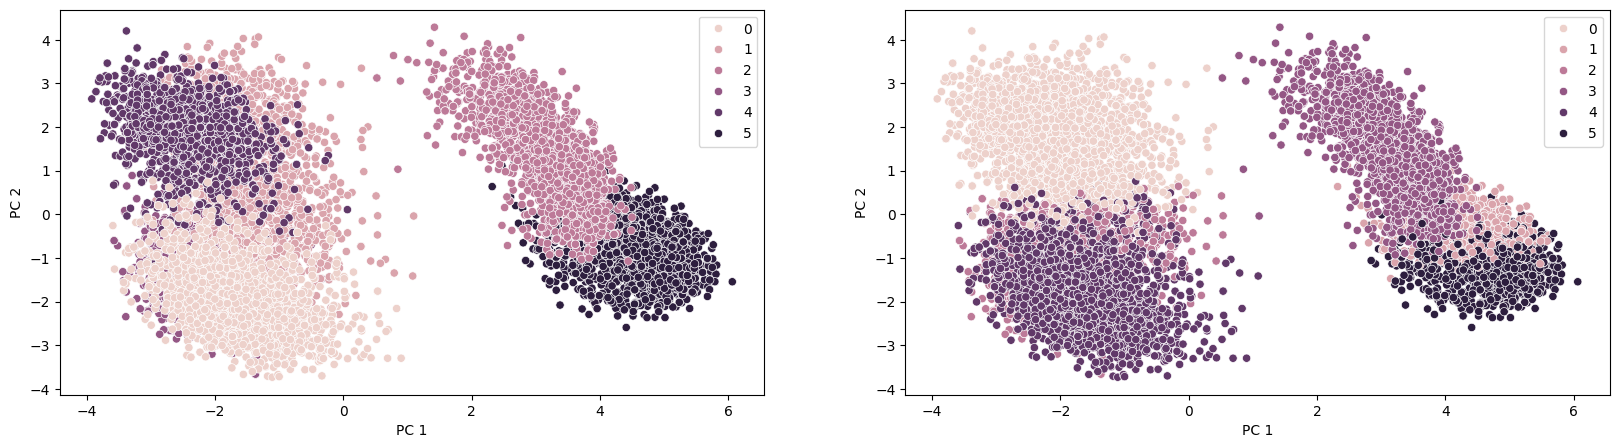

In [327]:
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
sns.scatterplot(x=pca_reduced_impt[:,0], y =pca_reduced_impt[:,1],hue=true_labels)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.subplot(1,2,2)
sns.scatterplot(x=pca_reduced_impt[:,0], y =pca_reduced_impt[:,1],hue=pca_results)
plt.xlabel('PC 1')
plt.ylabel('PC 2')

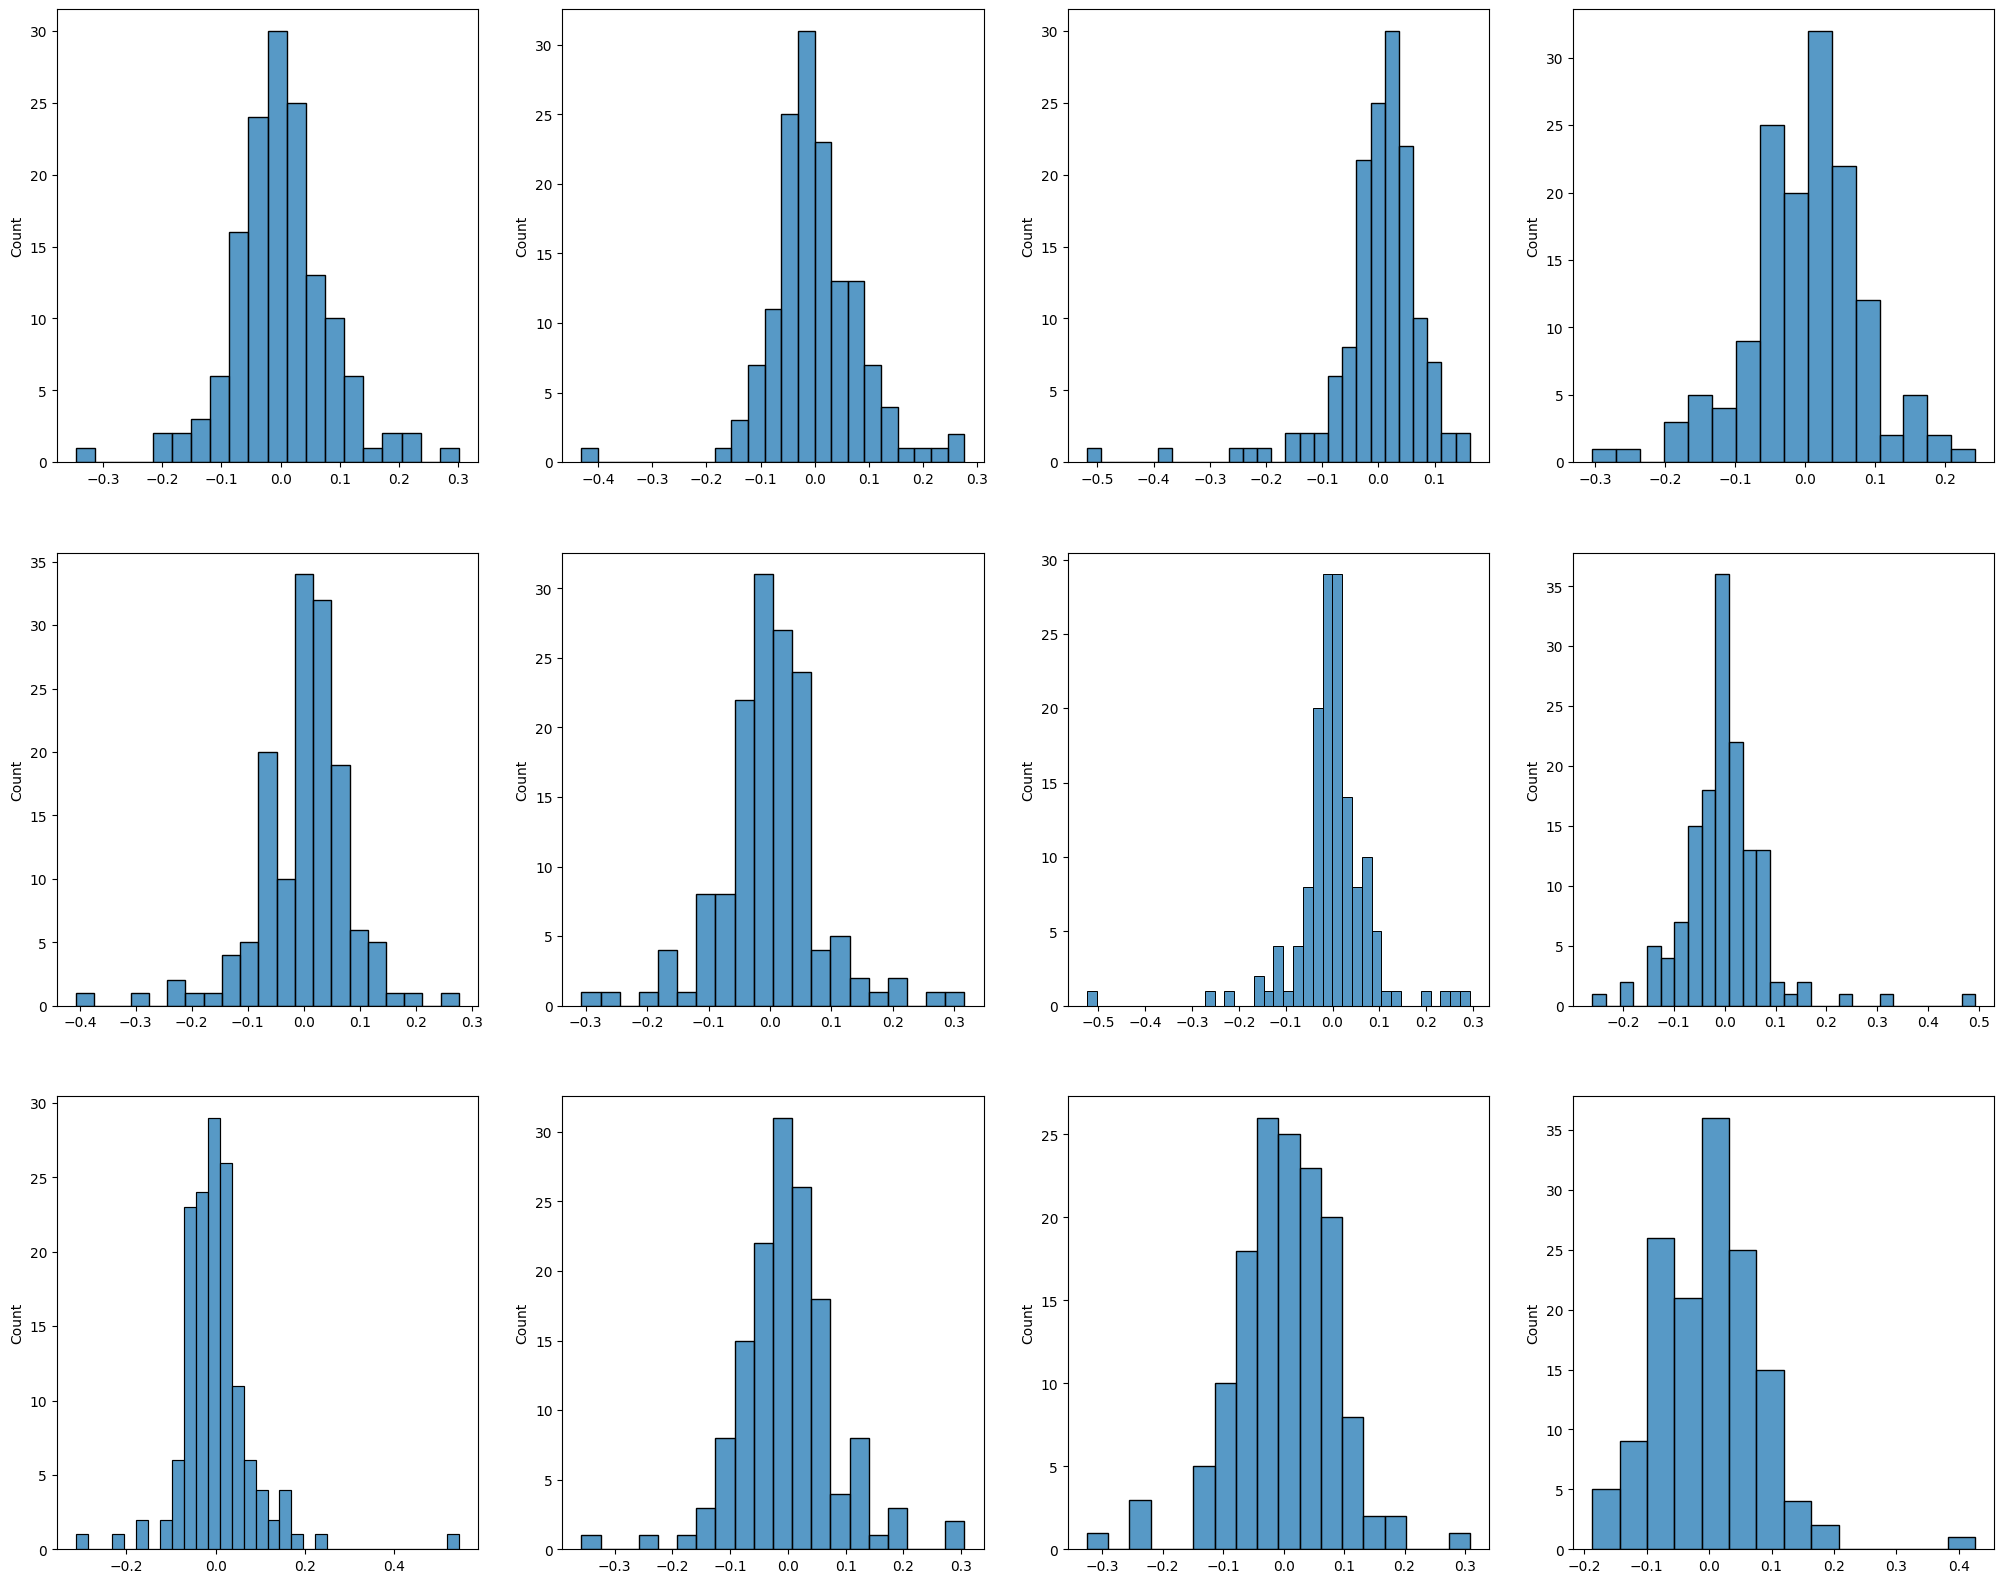

In [277]:
plt.figure(figsize = (25, 20))
for i,component in enumerate(pca.components_[:12]):
  plt.subplot(3,4, i+1)
  sns.histplot(component)


In [104]:
fit_linreg(np.log(importances), tasks)
fit_linreg(pca_reduced_impt,  tasks)

train accuracy: 1.0
test accuracy: 1.0
train accuracy: 1.0
test accuracy: 1.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



(1.0, 1.0)

In [177]:
prompts = []
for batch in tqdm(dl):
  prompts.append(" ".join(tokenizer.batch_decode(batch[0].squeeze())).replace("<|endoftext|> ", ""))


  0%|          | 0/5484 [00:00<?, ?it/s]/content/drive/Shareddrives/Confidence Probes/taskdiscovery/data.py:558: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/content/drive/Shareddrives/Confidence Probes/taskdiscovery/data.py:559: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

100%|██████████| 5484/5484 [00:05<00:00, 1082.03it/s]


In [205]:
results_df = pd.DataFrame({"pc 0" : pca_reduced_impt[:,0], "prompt": prompts})
results_df["category"] = (results_df["pc 0"] > results_df["pc 0"].mean()).astype(int)
results_df["task"] = true_labels
results_df = results_df.sort_values("pc 0").drop_duplicates().reset_index(drop=True)

results_df["score"] = results_df.apply(lambda x : common_words_score(x), axis = 1)

pd.concat([results_df[results_df["task"] == 2].head(10), results_df[results_df["task"] == 2].tail(10)])

,pc 0,prompt,category,task,score
0,-106.781403,Q : blender \n A : bl enders \n \n Q : tong...,0,2,8547
1,-103.915176,Q : shirt \n A : shirts \n \n Q : oven \n A...,0,2,6137
2,-100.276024,Q : bat \n A : bats \n \n Q : clock \n A : ...,0,2,8842
3,-99.892265,Q : motorcycle \n A : motorcycles \n \n Q : ...,0,2,7989
4,-99.548355,Q : perfume \n A : perf umes \n \n Q : col ...,0,2,6149
5,-97.019211,Q : gr ater \n A : gr aters \n \n Q : axe \...,0,2,8318
6,-96.603081,Q : vacuum \n A : vac u ums \n \n Q : islan...,0,2,6123
7,-95.881119,Q : fabric \n A : fabrics \n \n Q : newspap...,0,2,7912
8,-95.613434,Q : computer \n A : computers \n \n Q : too...,0,2,8643
9,-94.976646,Q : computer \n A : computers \n \n Q : mou...,0,2,7217


In [206]:
results_df.corr()

<ipython-input-206-419e2a40607f>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,pc 0,category,task,score
pc 0,1.000000,0.782241,-0.510415,-0.375975
category,0.782241,1.000000,-0.419008,-0.318148
task,-0.510415,-0.419008,1.000000,0.671520
score,-0.375975,-0.318148,0.671520,1.000000


In [204]:
d = {}
for prompt in prompts:

  for word in prompt.split(" "):
    if word in ["Q", ":", "A", "", "\n"] or len(word) < 3:
      continue
    else:
      if word in d:
        d[word] += 1
      else:
        d[word] = 1

def common_words_score(row):
  prompt = row["prompt"]
  score = 0
  for word in prompt.split(" "):
    if word in ["Q", ":", "A", "", "\n"]  or len(word) < 3:
      continue
    else:
      score += d[word]
  return score



In [201]:
label_encoder.fit_transform( results_df["score"].to_numpy()).max()

165

In [200]:
results_df["score"].to_numpy()

array([ 28, 440,  28, ...,   1, 167,   9])

In [203]:
labels = label_encoder.fit_transform( results_df["score"].to_numpy())
lm = LogisticRegression(random_state=0).fit(np.expand_dims(results_df["pc 0"].to_numpy(),1), labels)

predicted_labels = lm.predict(np.expand_dims(results_df["pc 0"].to_numpy(),1))

# Calculate "accuracy"
accuracy = accuracy_score( labels, predicted_labels)
print(f"train accuracy: {accuracy}")

train accuracy: 0.04892891918208374


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



AttributeError: 'numpy.ndarray' object has no attribute 'expand_dims'

In [158]:
dict(sorted(d.items(), key=lambda item: item[1],reverse=True))

{'tooth': 646,
 'ers': 541,
 'brush': 491,
 'st': 469,
 's': 440,
 'trash': 374,
 'lad': 364,
 'h': 362,
 'ushes': 343,
 'paint': 340,
 'ry': 333,
 'a': 328,
 'tong': 328,
 'matches': 323,
 'gr': 320,
 'br': 320,
 'le': 310,
 'er': 308,
 'ha': 298,
 'ird': 298,
 'spread': 256,
 'tape': 253,
 'newspaper': 243,
 'can': 228,
 'sticks': 224,
 'mouse': 217,
 'motorcycle': 214,
 'fork': 213,
 'bat': 207,
 'newspapers': 201,
 'clock': 201,
 'oe': 200,
 'bus': 199,
 'so': 198,
 'pl': 197,
 'cans': 197,
 'soap': 196,
 'lipstick': 194,
 'destroy': 193,
 'qualify': 191,
 'cloud': 189,
 'buses': 189,
 'es': 188,
 'tapes': 188,
 'clocks': 188,
 'ful': 184,
 'aps': 184,
 'lip': 184,
 'clouds': 183,
 'fabric': 183,
 'bats': 183,
 'glue': 181,
 'hat': 180,
 'magazine': 178,
 'r': 176,
 'les': 174,
 'axe': 174,
 'verify': 172,
 'fabrics': 172,
 'paste': 172,
 'poster': 172,
 'm': 171,
 'pler': 170,
 'mice': 170,
 'gl': 170,
 'ues': 170,
 'computer': 169,
 'house': 169,
 'check': 168,
 'magazines': 168,

In [51]:
" ".join(tokenizer.batch_decode(batch[0][batch[1]]))

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [127]:
kmeans = KMeans(n_clusters=3,n_init = "auto", random_state=0).fit(pca_reduced_impt)
predicted_labels = kmeans.labels_

Text(0, 0.5, 'PC 2')

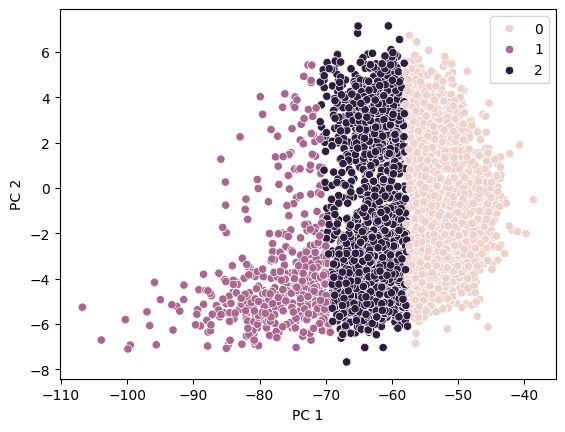

In [128]:
sns.scatterplot(x=pca_reduced_impt[:,0], y =pca_reduced_impt[:,1],hue=predicted_labels)
plt.xlabel('PC 1')
plt.ylabel('PC 2')

In [ ]:
np.linalg.norm(np.log(importances), axis=-1)

array([57.94101 , 64.73528 , 63.35975 , ..., 57.7258  , 68.086815,
       57.094303], dtype=float32)

In [ ]:
def pca_project(x, dim, weighted=True):
    xv = x
    if not weighted:
        xv = x / x.var(0)
    u, d, v = torch.pca_lowrank(xv,dim+10)
    return torch.matmul(x,v[:,:dim])

In [ ]:
norm_X = (big_X - big_X.mean(0)) / big_X.var(0)

<Axes: ylabel='Count'>

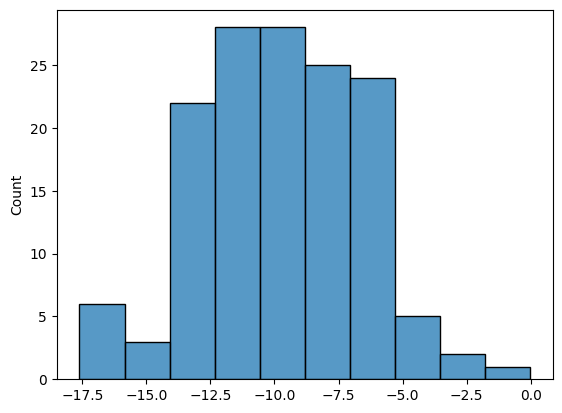

In [ ]:
sns.histplot(np.log(big_X.var(0)))

In [ ]:
(big_X < 1e-4).sum()

2538

In [ ]:
big_X.var(0)

array([[1.1755037e-03, 1.3670120e+00, 1.8443628e-03, ..., 3.3018538e-03,
        2.7158054e-02, 1.6401056e-04],
       [1.3448875e-03, 1.8861841e+00, 1.1630161e-03, ..., 1.4595613e-03,
        3.2474864e-03, 1.5804169e-03],
       [1.9562722e-04, 3.1992290e+00, 2.5941050e-03, ..., 2.1240897e-03,
        6.9699949e-04, 9.6067414e-04],
       ...,
       [5.1921536e-03, 4.4849089e-01, 1.1895746e-03, ..., 1.5509469e-02,
        2.5116937e-04, 3.7080487e-03],
       [1.5250899e-02, 3.8596103e-01, 5.8716144e-03, ..., 2.6388790e-02,
        2.8858386e-02, 5.1989192e-03],
       [2.5181696e-03, 2.5367576e-01, 8.4232073e-04, ..., 4.4700980e-02,
        6.8214955e-05, 7.3381402e-03]], dtype=float32)

In [ ]:
big_X+1e-8

array([[1.1755137e-03, 1.3670120e+00, 1.8443728e-03, ..., 3.3018638e-03,
        2.7158063e-02, 1.6402056e-04],
       [1.3448976e-03, 1.8861841e+00, 1.1630261e-03, ..., 1.4595713e-03,
        3.2474964e-03, 1.5804269e-03],
       [1.9563721e-04, 3.1992290e+00, 2.5941150e-03, ..., 2.1240998e-03,
        6.9700950e-04, 9.6068415e-04],
       ...,
       [5.1921634e-03, 4.4849089e-01, 1.1895846e-03, ..., 1.5509480e-02,
        2.5117939e-04, 3.7080587e-03],
       [1.5250909e-02, 3.8596103e-01, 5.8716242e-03, ..., 2.6388800e-02,
        2.8858395e-02, 5.1989290e-03],
       [2.5181796e-03, 2.5367576e-01, 8.4233074e-04, ..., 4.4700991e-02,
        6.8224952e-05, 7.3381499e-03]], dtype=float32)

In [ ]:
data_ts = np.log(big_X+1e-6)

In [ ]:
data_ts = norm_X

<Axes: ylabel='Count'>

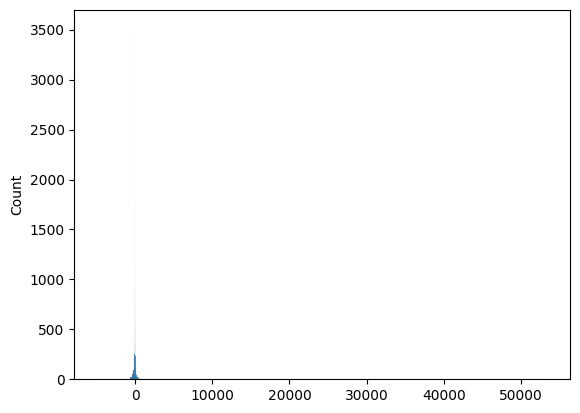

In [ ]:
sns.histplot(data_ts.flatten())